In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nltk
import re
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from eunjeon import Mecab

In [2]:
# 데이터셋 클래스 정의
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.sentences1 = df['사람문장1'].values
        self.sentences2 = df['사람문장2'].values
        self.sentences3 = df['사람문장3'].values
        self.emotions = df['감정_대분류'].values
        self.situations = df['상황키워드'].values

        # Token to index mapping dictionary
        all_sentences = list(self.sentences1) + list(self.sentences2) + list(self.sentences3)
        self.token_to_idx = {token: idx for idx, token in enumerate(tokenizer.morphs(' '.join(all_sentences)))}
        self.token_to_idx['<PAD>'] = len(self.token_to_idx)  # Padding token
        self.token_to_idx['<UNK>'] = len(self.token_to_idx)  # Unknown token
        self.vocab_size = len(self.token_to_idx)

    def __len__(self):
        return len(self.sentences1)

    def __getitem__(self, idx):
        sentence1 = self.sentences1[idx]
        sentence2 = self.sentences2[idx]
        sentence3 = self.sentences3[idx]
        emotion = self.emotions[idx]
        situation = self.situations[idx]

        # Tokenize sentences and apply padding
        tokens1 = self.tokenizer.morphs(sentence1)
        tokens2 = self.tokenizer.morphs(sentence2)
        tokens3 = self.tokenizer.morphs(sentence3)
        
        tokens_list = [tokens1, tokens2, tokens3]
        input_ids_list = []
        for tokens in tokens_list:
            if len(tokens) < self.max_length:
                tokens += ['<PAD>'] * (self.max_length - len(tokens))
            else:
                tokens = tokens[:self.max_length]
            # Convert tokens to input IDs
            input_ids = [self.token_to_idx.get(token, self.token_to_idx['<UNK>']) for token in tokens]
            input_ids_list.append(input_ids)

        return {
            'input_ids1': torch.tensor(input_ids_list[0]),
            'input_ids2': torch.tensor(input_ids_list[1]),
            'input_ids3': torch.tensor(input_ids_list[2]),
            'emotion': emotion,
            'situation': situation
        }

In [3]:
# RNN 모델 정의
class RNNModel(nn.Module):
    def __init__(self, vocab_size, num_emotions, num_situations, input_size=200, hidden_size=128):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)  # 추가적인 완전 연결 레이어
        self.fc2 = nn.Linear(64, num_emotions)  # 추가적인 완전 연결 레이어
        self.fc3 = nn.Linear(hidden_size, 64)  # 추가적인 완전 연결 레이어
        self.fc4 = nn.Linear(64, num_situations)  # 추가적인 완전 연결 레이어

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        rnn_output, _ = self.rnn(embedded)
        pooled_output = rnn_output.mean(dim=1)
        emotion_logits = self.fc1(pooled_output)
        emotion_logits = self.fc2(emotion_logits)
        situation_logits = self.fc3(pooled_output)
        situation_logits = self.fc4(situation_logits)

        return emotion_logits, situation_logits

In [4]:
data_dir = '../analysis_files/files/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# mecab 모델 다운로드
tokenizer = Mecab()

In [5]:
# 감성대화말뭉치(최종데이터)_Training.csv 파일을 pandas로 읽어옵니다.
df = pd.read_csv(os.path.join(data_dir, '감성대화말뭉치(최종데이터)_Validation2.csv'), encoding='cp949')
df = df[['사람문장1', '사람문장2', '사람문장3', '감정_대분류', '상황키워드']]

# NaN 값과 빈 문자열 제거
df.dropna(subset=['사람문장3'], inplace=True)
df = df[df.astype(str).ne('').all(axis=1)]

In [6]:
# 레이블 인코딩
emotion_encoder = LabelEncoder()
df['emotion'] = emotion_encoder.fit_transform(df['감정_대분류'])
situation_encoder = LabelEncoder()
df['situation'] = situation_encoder.fit_transform(df['상황키워드'])

In [7]:
# 데이터 분할
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 데이터셋 초기화
train_dataset = SentimentDataset(train_df, tokenizer, max_length=16)
test_dataset = SentimentDataset(test_df, tokenizer, max_length=16)

# 데이터로더 초기화
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [8]:
# 모델 초기화
vocab_size = train_dataset.vocab_size
num_emotions = len(emotion_encoder.classes_)
num_situations = len(situation_encoder.classes_)
model = RNNModel(vocab_size, num_emotions, num_situations)

# 손실 함수, 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [9]:
# 평가 함수 정의
def evaluate(model, dataloader):
    model.eval()
    y_true_emotion = []
    y_pred_emotion = []
    y_true_situation = []
    y_pred_situation = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids1 = batch['input_ids1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            input_ids3 = batch['input_ids3'].to(device)
            emotion_labels = torch.tensor(emotion_encoder.transform(batch['emotion']), dtype=torch.long).to(device)
            situation_labels = torch.tensor(situation_encoder.transform(batch['situation']), dtype=torch.long).to(device)
            
            # input_ids1, input_ids2, input_ids3에 있는 토큰들을 최대 임베딩 크기보다 작은 값으로 clamp
            input_ids1 = torch.clamp(input_ids1, max=vocab_size - 1)
            input_ids2 = torch.clamp(input_ids2, max=vocab_size - 1)
            input_ids3 = torch.clamp(input_ids3, max=vocab_size - 1)
            
            emotion_logits1, situation_logits1 = model(input_ids1)
            emotion_logits2, situation_logits2 = model(input_ids2)
            emotion_logits3, situation_logits3 = model(input_ids3)

            # Combine logits from all three models (average or max, depending on your choice)
            emotion_logits = (emotion_logits1 + emotion_logits2 + emotion_logits3) / 3
            situation_logits = (situation_logits1 + situation_logits2 + situation_logits3) / 3

            _, predicted_emotion = torch.max(emotion_logits, 1)
            _, predicted_situation = torch.max(situation_logits, 1)

            y_true_emotion.extend(emotion_labels.tolist())
            y_pred_emotion.extend(predicted_emotion.tolist())
            y_true_situation.extend(situation_labels.tolist())
            y_pred_situation.extend(predicted_situation.tolist())

    accuracy_emotion = accuracy_score(y_true_emotion, y_pred_emotion)
    recall_emotion = recall_score(y_true_emotion, y_pred_emotion, average='macro')
    f1_emotion = f1_score(y_true_emotion, y_pred_emotion, average='macro')
    accuracy_situation = accuracy_score(y_true_situation, y_pred_situation)
    recall_situation = recall_score(y_true_situation, y_pred_situation, average='macro')
    f1_situation = f1_score(y_true_situation, y_pred_situation, average='macro')

    return accuracy_emotion, recall_emotion, f1_emotion, accuracy_situation, recall_situation, f1_situation



In [10]:
# 학습 함수 정의
num_epochs = 100
train_acc_emotion_list = []
train_acc_situation_list = []
test_acc_emotion_list = []
test_acc_situation_list = []

model = model.to(device)  # 모델을 GPU로 이동

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:02}/{:02}'.format(epoch+1, num_epochs), leave=False)
    for batch in progress_bar:
        input_ids1 = batch['input_ids1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        input_ids3 = batch['input_ids3'].to(device)
        emotion_labels = torch.tensor(emotion_encoder.transform(batch['emotion']), dtype=torch.long).to(device)
        situation_labels = torch.tensor(situation_encoder.transform(batch['situation']), dtype=torch.long).to(device)

        optimizer.zero_grad()
        # input_ids1, input_ids2, input_ids3에 있는 토큰들을 최대 임베딩 크기보다 작은 값으로 clamp
        input_ids1 = torch.clamp(input_ids1, max=vocab_size - 1)
        input_ids2 = torch.clamp(input_ids2, max=vocab_size - 1)
        input_ids3 = torch.clamp(input_ids3, max=vocab_size - 1)
        
        optimizer.zero_grad()
        
        # 문장1, 문장2, 문장3에 대해 각각 모델을 수행
        emotion_logits1, situation_logits1 = model(input_ids1)
        emotion_logits2, situation_logits2 = model(input_ids2)
        emotion_logits3, situation_logits3 = model(input_ids3)

        # 세 모델의 출력값을 평균 또는 최댓값으로 통합하여 최종 출력값 계산
        emotion_logits = (emotion_logits1 + emotion_logits2 + emotion_logits3) / 3
        situation_logits = (situation_logits1 + situation_logits2 + situation_logits3) / 3
        
        emotion_loss = criterion(emotion_logits, emotion_labels)
        situation_loss = criterion(situation_logits, situation_labels)
        loss = emotion_loss + situation_loss

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * input_ids1.size(0)
        progress_bar.set_postfix({'train_loss': train_loss / len(train_dataset)})

    # 검증
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids1 = batch['input_ids1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            input_ids3 = batch['input_ids3'].to(device)
            emotion_labels = torch.tensor(emotion_encoder.transform(batch['emotion']), dtype=torch.long).to(device)
            situation_labels = torch.tensor(situation_encoder.transform(batch['situation']), dtype=torch.long).to(device)
            
            # input_ids1, input_ids2, input_ids3에 있는 토큰들을 최대 임베딩 크기보다 작은 값으로 clamp
            input_ids1 = torch.clamp(input_ids1, max=vocab_size - 1)
            input_ids2 = torch.clamp(input_ids2, max=vocab_size - 1)
            input_ids3 = torch.clamp(input_ids3, max=vocab_size - 1)
                        
            # 문장1, 문장2, 문장3에 대해 각각 모델을 수행
            emotion_logits1, situation_logits1 = model(input_ids1)
            emotion_logits2, situation_logits2 = model(input_ids2)
            emotion_logits3, situation_logits3 = model(input_ids3)

            # 세 모델의 출력값을 평균 또는 최댓값으로 통합하여 최종 출력값 계산
            emotion_logits = (emotion_logits1 + emotion_logits2 + emotion_logits3) / 3
            situation_logits = (situation_logits1 + situation_logits2 + situation_logits3) / 3

            emotion_loss = criterion(emotion_logits, emotion_labels)
            situation_loss = criterion(situation_logits, situation_labels)
            loss = emotion_loss + situation_loss

            test_loss += loss.item() * input_ids1.size(0)

    # 학습 데이터에 대한 평가
    train_accuracy_emotion, train_recall_emotion, train_f1_emotion, train_accuracy_situation, train_recall_situation, train_f1_situation = evaluate(model, train_dataloader)
    # 테스트 데이터에 대한 평가
    test_accuracy_emotion, test_recall_emotion, test_f1_emotion, test_accuracy_situation, test_recall_situation, test_f1_situation = evaluate(model, test_dataloader)

    # Append accuracy values to the lists
    train_acc_emotion_list.append(train_accuracy_emotion)
    train_acc_situation_list.append(train_accuracy_situation)
    test_acc_emotion_list.append(test_accuracy_emotion)
    test_acc_situation_list.append(test_accuracy_situation)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Emotion Accuracy: {train_accuracy_emotion:.4f} Recall: {train_recall_emotion:.4f} F1-score: {train_f1_emotion:.4f}")
    print(f"Train Situation Accuracy: {train_accuracy_situation:.4f} Recall: {train_recall_situation:.4f} F1-score: {train_f1_situation:.4f}")
    print(f"Test Emotion Accuracy: {test_accuracy_emotion:.4f} Recall: {test_recall_emotion:.4f} F1-score: {test_f1_emotion:.4f}")
    print(f"Test Situation Accuracy: {test_accuracy_situation:.4f} Recall: {test_recall_situation:.4f} F1-score: {test_f1_situation:.4f}")
    print()

Epoch 1/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1971 Recall: 0.1667 F1-score: 0.0551
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 2/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1971 Recall: 0.1673 F1-score: 0.0610
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 3/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1971 Recall: 0.1667 F1-score: 0.0550
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 4/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1982 Recall: 0.1678 F1-score: 0.0574
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 5/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1971 Recall: 0.1675 F1-score: 0.0628
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 6/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1982 Recall: 0.1680 F1-score: 0.0594
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 7/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1982 Recall: 0.1680 F1-score: 0.0593
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 8/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1948 Recall: 0.1738 F1-score: 0.0908
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 9/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1982 Recall: 0.1680 F1-score: 0.0594
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 10/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1982 Recall: 0.1680 F1-score: 0.0593
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 11/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1881 Recall: 0.1594 F1-score: 0.0567
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 12/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1948 Recall: 0.1655 F1-score: 0.0613
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 13/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1971 Recall: 0.1667 F1-score: 0.0550
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 14/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1982 Recall: 0.1678 F1-score: 0.0574
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 15/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1475 Recall: 0.1667 F1-score: 0.0429
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 16/100:
Train Emotion Accuracy: 0.1928 Recall: 0.1831 F1-score: 0.0950
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1475 Recall: 0.1667 F1-score: 0.0429
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 17/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1858 Recall: 0.1578 F1-score: 0.0579
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 18/100:
Train Emotion Accuracy: 0.1920 Recall: 0.1794 F1-score: 0.0937
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1565 Recall: 0.1727 F1-score: 0.0629
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 19/100:
Train Emotion Accuracy: 0.1923 Recall: 0.1797 F1-score: 0.0938
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1565 Recall: 0.1719 F1-score: 0.0714
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 20/100:
Train Emotion Accuracy: 0.1928 Recall: 0.1831 F1-score: 0.0950
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1475 Recall: 0.1667 F1-score: 0.0429
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 21/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1858 Recall: 0.1578 F1-score: 0.0579
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 22/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1498 Recall: 0.1683 F1-score: 0.0483
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 23/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1475 Recall: 0.1667 F1-score: 0.0429
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 24/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1475 Recall: 0.1667 F1-score: 0.0429
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 25/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1486 Recall: 0.1670 F1-score: 0.0480
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 26/100:
Train Emotion Accuracy: 0.1920 Recall: 0.1794 F1-score: 0.0937
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1532 Recall: 0.1692 F1-score: 0.0606
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 27/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1813 Recall: 0.1553 F1-score: 0.0623
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 28/100:
Train Emotion Accuracy: 0.1923 Recall: 0.1797 F1-score: 0.0938
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1543 Recall: 0.1701 F1-score: 0.0620
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 29/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1971 Recall: 0.1667 F1-score: 0.0552
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 30/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1486 Recall: 0.1670 F1-score: 0.0480
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 31/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1959 Recall: 0.1663 F1-score: 0.0607
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 32/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1475 Recall: 0.1667 F1-score: 0.0429
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 33/100:
Train Emotion Accuracy: 0.1931 Recall: 0.1834 F1-score: 0.0951
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1475 Recall: 0.1667 F1-score: 0.0429
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 34/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1802 Recall: 0.1549 F1-score: 0.0643
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 35/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1802 Recall: 0.1549 F1-score: 0.0643
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 36/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1813 Recall: 0.1556 F1-score: 0.0635
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 37/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1498 Recall: 0.1683 F1-score: 0.0483
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 38/100:
Train Emotion Accuracy: 0.1937 Recall: 0.1670 F1-score: 0.0547
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1622 Recall: 0.1528 F1-score: 0.0794
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 39/100:
Train Emotion Accuracy: 0.1920 Recall: 0.1795 F1-score: 0.0937
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1509 Recall: 0.1689 F1-score: 0.0516
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 40/100:
Train Emotion Accuracy: 0.1923 Recall: 0.1797 F1-score: 0.0938
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1520 Recall: 0.1686 F1-score: 0.0582
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 41/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1836 Recall: 0.1607 F1-score: 0.0733
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 42/100:
Train Emotion Accuracy: 0.1923 Recall: 0.1797 F1-score: 0.0938
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1543 Recall: 0.1714 F1-score: 0.0580
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 43/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1700 Recall: 0.1569 F1-score: 0.0800
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 44/100:
Train Emotion Accuracy: 0.1923 Recall: 0.1795 F1-score: 0.0937
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1622 Recall: 0.1739 F1-score: 0.0763
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 45/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1813 Recall: 0.1565 F1-score: 0.0667
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 46/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1486 Recall: 0.1673 F1-score: 0.0464
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 47/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1802 Recall: 0.1594 F1-score: 0.0755
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 48/100:
Train Emotion Accuracy: 0.1926 Recall: 0.1799 F1-score: 0.0939
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1599 Recall: 0.1727 F1-score: 0.0734
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 49/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1937 Recall: 0.1641 F1-score: 0.0571
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 50/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1700 Recall: 0.1569 F1-score: 0.0800
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 51/100:
Train Emotion Accuracy: 0.1923 Recall: 0.1797 F1-score: 0.0938
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1520 Recall: 0.1698 F1-score: 0.0534
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 52/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1813 Recall: 0.1565 F1-score: 0.0667
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 53/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1757 Recall: 0.1572 F1-score: 0.0766
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 54/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1475 Recall: 0.1667 F1-score: 0.0429
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 55/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1745 Recall: 0.1566 F1-score: 0.0766
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 56/100:
Train Emotion Accuracy: 0.1917 Recall: 0.1792 F1-score: 0.0935
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1475 Recall: 0.1667 F1-score: 0.0429
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 57/100:
Train Emotion Accuracy: 0.1906 Recall: 0.1785 F1-score: 0.0966
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1475 Recall: 0.1660 F1-score: 0.0461
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 58/100:
Train Emotion Accuracy: 0.1920 Recall: 0.1794 F1-score: 0.0947
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1610 Recall: 0.1730 F1-score: 0.0753
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 59/100:
Train Emotion Accuracy: 0.1940 Recall: 0.1673 F1-score: 0.0552
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1633 Recall: 0.1544 F1-score: 0.0801
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 60/100:
Train Emotion Accuracy: 0.1926 Recall: 0.1799 F1-score: 0.0939
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1543 Recall: 0.1698 F1-score: 0.0633
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 61/100:
Train Emotion Accuracy: 0.1937 Recall: 0.1670 F1-score: 0.0552
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1734 Recall: 0.1598 F1-score: 0.0814
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 62/100:
Train Emotion Accuracy: 0.1943 Recall: 0.1676 F1-score: 0.0558
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1768 Recall: 0.1604 F1-score: 0.0800
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 63/100:
Train Emotion Accuracy: 0.1937 Recall: 0.1672 F1-score: 0.0573
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1734 Recall: 0.1611 F1-score: 0.0826
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 64/100:
Train Emotion Accuracy: 0.1914 Recall: 0.1793 F1-score: 0.0982
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1520 Recall: 0.1705 F1-score: 0.0505
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 65/100:
Train Emotion Accuracy: 0.1937 Recall: 0.1672 F1-score: 0.0568
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1655 Recall: 0.1614 F1-score: 0.0838
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 66/100:
Train Emotion Accuracy: 0.1943 Recall: 0.1677 F1-score: 0.0569
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1667 Recall: 0.1624 F1-score: 0.0843
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 67/100:
Train Emotion Accuracy: 0.1951 Recall: 0.1860 F1-score: 0.1072
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1475 Recall: 0.1667 F1-score: 0.0429
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 68/100:
Train Emotion Accuracy: 0.1920 Recall: 0.1795 F1-score: 0.0948
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1588 Recall: 0.1733 F1-score: 0.0693
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 69/100:
Train Emotion Accuracy: 0.1920 Recall: 0.1795 F1-score: 0.0948
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1520 Recall: 0.1676 F1-score: 0.0618
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 70/100:
Train Emotion Accuracy: 0.1912 Recall: 0.1788 F1-score: 0.0935
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1498 Recall: 0.1686 F1-score: 0.0467
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 71/100:
Train Emotion Accuracy: 0.1962 Recall: 0.1702 F1-score: 0.0692
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1712 Recall: 0.1553 F1-score: 0.0776
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 72/100:
Train Emotion Accuracy: 0.1926 Recall: 0.1816 F1-score: 0.1124
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1610 Recall: 0.1746 F1-score: 0.0726
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 73/100:
Train Emotion Accuracy: 0.1962 Recall: 0.1702 F1-score: 0.0692
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1723 Recall: 0.1588 F1-score: 0.0810
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 74/100:
Train Emotion Accuracy: 0.1943 Recall: 0.1680 F1-score: 0.0619
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1700 Recall: 0.1608 F1-score: 0.0836
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 75/100:
Train Emotion Accuracy: 0.1951 Recall: 0.1856 F1-score: 0.1228
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1565 Recall: 0.1714 F1-score: 0.0670
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 76/100:
Train Emotion Accuracy: 0.1957 Recall: 0.1708 F1-score: 0.0787
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1723 Recall: 0.1671 F1-score: 0.0873
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 77/100:
Train Emotion Accuracy: 0.1951 Recall: 0.1689 F1-score: 0.0636
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1678 Recall: 0.1624 F1-score: 0.0851
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 78/100:
Train Emotion Accuracy: 0.1951 Recall: 0.1848 F1-score: 0.1192
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1577 Recall: 0.1717 F1-score: 0.0698
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 79/100:
Train Emotion Accuracy: 0.1945 Recall: 0.1695 F1-score: 0.0756
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1779 Recall: 0.1578 F1-score: 0.0753
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 80/100:
Train Emotion Accuracy: 0.1962 Recall: 0.1702 F1-score: 0.0692
Train Situation Accuracy: 0.1996 Recall: 0.0838 F1-score: 0.0286
Test Emotion Accuracy: 0.1757 Recall: 0.1505 F1-score: 0.0609
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 81/100:
Train Emotion Accuracy: 0.1937 Recall: 0.1829 F1-score: 0.1148
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1588 Recall: 0.1724 F1-score: 0.0718
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 82/100:
Train Emotion Accuracy: 0.1971 Recall: 0.1712 F1-score: 0.0714
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1655 Recall: 0.1608 F1-score: 0.0843
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 83/100:
Train Emotion Accuracy: 0.1948 Recall: 0.1683 F1-score: 0.0591
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1802 Recall: 0.1607 F1-score: 0.0777
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 84/100:
Train Emotion Accuracy: 0.1968 Recall: 0.1729 F1-score: 0.0861
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1689 Recall: 0.1569 F1-score: 0.0808
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 85/100:
Train Emotion Accuracy: 0.1948 Recall: 0.1833 F1-score: 0.1107
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1543 Recall: 0.1673 F1-score: 0.0697
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 86/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1825 F1-score: 0.1136
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1610 Recall: 0.1762 F1-score: 0.0706
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 87/100:
Train Emotion Accuracy: 0.1985 Recall: 0.1752 F1-score: 0.0904
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1644 Recall: 0.1592 F1-score: 0.0838
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 88/100:
Train Emotion Accuracy: 0.1957 Recall: 0.1693 F1-score: 0.0633
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1633 Recall: 0.1550 F1-score: 0.0810
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 89/100:
Train Emotion Accuracy: 0.1951 Recall: 0.1703 F1-score: 0.0779
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1655 Recall: 0.1605 F1-score: 0.0843
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 90/100:
Train Emotion Accuracy: 0.1948 Recall: 0.1829 F1-score: 0.1070
Train Situation Accuracy: 0.1990 Recall: 0.0833 F1-score: 0.0277
Test Emotion Accuracy: 0.1610 Recall: 0.1768 F1-score: 0.0686
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 91/100:
Train Emotion Accuracy: 0.1971 Recall: 0.1712 F1-score: 0.0714
Train Situation Accuracy: 0.1993 Recall: 0.0839 F1-score: 0.0288
Test Emotion Accuracy: 0.1633 Recall: 0.1547 F1-score: 0.0810
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 92/100:
Train Emotion Accuracy: 0.1957 Recall: 0.1862 F1-score: 0.1231
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1577 Recall: 0.1714 F1-score: 0.0711
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 93/100:
Train Emotion Accuracy: 0.1954 Recall: 0.1691 F1-score: 0.0641
Train Situation Accuracy: 0.1993 Recall: 0.0839 F1-score: 0.0288
Test Emotion Accuracy: 0.1734 Recall: 0.1585 F1-score: 0.0800
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 94/100:
Train Emotion Accuracy: 0.1934 Recall: 0.1813 F1-score: 0.1021
Train Situation Accuracy: 0.1993 Recall: 0.0839 F1-score: 0.0288
Test Emotion Accuracy: 0.1577 Recall: 0.1714 F1-score: 0.0709
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 95/100:
Train Emotion Accuracy: 0.1943 Recall: 0.1841 F1-score: 0.1188
Train Situation Accuracy: 0.1996 Recall: 0.0841 F1-score: 0.0293
Test Emotion Accuracy: 0.1565 Recall: 0.1692 F1-score: 0.0720
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 96/100:
Train Emotion Accuracy: 0.1931 Recall: 0.1822 F1-score: 0.1127
Train Situation Accuracy: 0.1993 Recall: 0.0839 F1-score: 0.0288
Test Emotion Accuracy: 0.1543 Recall: 0.1673 F1-score: 0.0696
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 97/100:
Train Emotion Accuracy: 0.1951 Recall: 0.1847 F1-score: 0.1186
Train Situation Accuracy: 0.1993 Recall: 0.0839 F1-score: 0.0288
Test Emotion Accuracy: 0.1543 Recall: 0.1673 F1-score: 0.0698
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 98/100:
Train Emotion Accuracy: 0.1971 Recall: 0.1712 F1-score: 0.0714
Train Situation Accuracy: 0.1996 Recall: 0.0841 F1-score: 0.0293
Test Emotion Accuracy: 0.1712 Recall: 0.1595 F1-score: 0.0822
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 99/100:
Train Emotion Accuracy: 0.1959 Recall: 0.1866 F1-score: 0.1237
Train Situation Accuracy: 0.1993 Recall: 0.0836 F1-score: 0.0282
Test Emotion Accuracy: 0.1588 Recall: 0.1727 F1-score: 0.0714
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



Epoch 100/100:
Train Emotion Accuracy: 0.1968 Recall: 0.1887 F1-score: 0.1283
Train Situation Accuracy: 0.1993 Recall: 0.0839 F1-score: 0.0288
Test Emotion Accuracy: 0.1599 Recall: 0.1739 F1-score: 0.0735
Test Situation Accuracy: 0.2241 Recall: 0.0833 F1-score: 0.0305



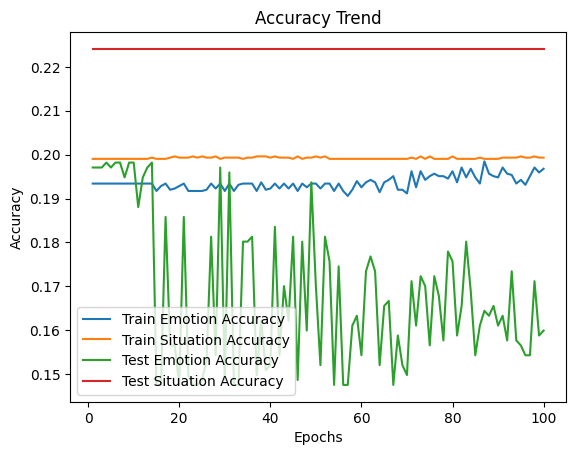

In [11]:
# Plotting the accuracy trend
epochs = range(1, num_epochs+1)

plt.plot(epochs, train_acc_emotion_list, label='Train Emotion Accuracy')
plt.plot(epochs, train_acc_situation_list, label='Train Situation Accuracy')
plt.plot(epochs, test_acc_emotion_list, label='Test Emotion Accuracy')
plt.plot(epochs, test_acc_situation_list, label='Test Situation Accuracy')

plt.title('Accuracy Trend')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 학습된 모델로 예측 수행
def predict_sentiment(model, sentence):
    model.eval()

    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids']

    emotion_logits, situation_logits = model(input_ids)
    emotion_probs = nn.functional.softmax(emotion_logits, dim=1).squeeze().cpu().detach().numpy()
    situation_probs = nn.functional.softmax(situation_logits, dim=1).squeeze().cpu().detach().numpy()

    emotion_label = emotion_encoder.inverse_transform([emotion_probs.argmax()])
    situation_label = situation_encoder.inverse_transform([situation_probs.argmax()])

    return emotion_label[0], situation_label[0]